In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os
from degree_days import dds



def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [4]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values

In [5]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
static_sd = sd_df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [6]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse
from common import compute_rmse_fraction


In [56]:
static_au

array([[ 0.204  ,      nan,      nan],
       [ 0.51175,  0.5    ,  0.75   ],
       [ 0.1515 ,      nan,      nan],
       ..., 
       [ 0.775  ,  0.25   ,  0.5    ],
       [ 0.204  ,      nan,      nan],
       [ 0.35   ,  0.5    ,  0.5    ]])

In [9]:
cost = 'abs'
case = 2
a = 5
b = 3
H_au, A_au, T_au = learn_HAT(case, au_tensor, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, H_known = static_au, T_known=np.ones(12).reshape(-1, 1))
    

In [55]:
A_au

array([[[  3.93400497e+00,   3.83978410e+00,   1.00504156e+01],
        [  4.45793169e+00,   0.00000000e+00,   1.59177172e+01],
        [  5.58696188e+00,   1.63885813e+01,   8.06183382e+00],
        [  7.12144329e+00,   8.92663472e+00,   2.55575303e+01],
        [  4.80224570e+00,   2.25064311e+01,   1.71928685e+00]],

       [[  0.00000000e+00,   5.56948230e+00,   0.00000000e+00],
        [  6.31545904e-02,   3.93635825e+00,   5.22871945e-02],
        [  0.00000000e+00,   1.10415218e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   1.88933768e+01,   0.00000000e+00]],

       [[  8.53148279e-01,   1.21691162e+00,   2.05052105e+00],
        [  1.25944208e+00,   8.66245226e-01,   1.72377123e+00],
        [  1.16533519e+00,   4.08314016e-01,   6.19245159e-01],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  1.25330446e+00,   5.99805097e-01,   9.01007056e-01]],

       [[  5.44911230e-01,   7.880

In [54]:
pred = {}
a = 5
b = 3
n_splits = 10
kf = KFold(n_splits = n_splits)

for method in ['normal','transfer']:
    pred[method] = {}
    for static_fac in ['static', 'None']:
        pred[method][static_fac] = {}
        for random_seed in range(5):
            pred[method][static_fac][random_seed] = {}
            for appliance in APPLIANCES_ORDER:
                pred[method][static_fac][random_seed][appliance] = {f:[] for f in range(10, 110, 40)}
for random_seed in range(5):
    np.random.seed(random_seed)
    for train_percentage in range(10, 110, 40):
        rd = 0
        for train_max, test in kf.split(sd_df):
            print (random_seed, train_percentage, rd)
            rd += 1

            num_train = int((train_percentage*len(train_max)/100)+0.5)
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0)
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]

            num_test = len(test_ix)
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t, dfc_t)


            # First n
            ################################################################
            # Normal learning in SanDiego
            ################################################################
#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, H_known = static_sd[np.concatenate([test, train])], T_known = np.ones(12).reshape(-1, 1))
#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 pred['normal']['static'][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, T_known = np.ones(12).reshape(-1, 1))
#             HAT = multiply_case(H, A, T, case)
#             for appliance in APPLIANCES_ORDER:
#                 pred['normal']['None'][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


#             tensor_copy = tensor.copy()
#             tensor_copy[:num_test, 1:, :] = np.NaN
#             H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, H_known = static_sd[np.concatenate([test, train])], A_known = A_au, T_known=np.ones(12).reshape(-1, 1))
#             HAT = multiply_case(H, A, T, case)
#             print HAT[0][0][0]
#             for appliance in APPLIANCES_ORDER:
#                 pred['transfer']['static'][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

           
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=3000, lr=0.1, dis=False, cost_function=cost, A_known = A_au, T_known=np.ones(12).reshape(-1, 1))
            HAT = multiply_case(H, A, T, case)
            print (HAT[0][0][0])
            for appliance in APPLIANCES_ORDER:
                pred['transfer']['None'][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


(0, 10, 0)
186.647480045
(0, 10, 1)
184.352040467
(0, 10, 2)
454.678321907
(0, 10, 3)
170.657228304
(0, 10, 4)
276.450212389
(0, 10, 5)
191.278651579
(0, 10, 6)
159.506246999
(0, 10, 7)
443.413884796
(0, 10, 8)
371.670091247
(0, 10, 9)
377.761149326
(0, 50, 0)
250.971830358
(0, 50, 1)
194.795707301
(0, 50, 2)
340.014553132
(0, 50, 3)
37.3472870838
(0, 50, 4)
33.5069211061
(0, 50, 5)
184.646094346
(0, 50, 6)
211.078119644
(0, 50, 7)
568.516598346
(0, 50, 8)


KeyboardInterrupt: 

In [50]:
out = {}

for method in ['transfer']:
    out[method] = {}
    for static_fac  in ['None']:
        out[method][static_fac] = {}
        for random_seed in range(5):
            out[method][static_fac][random_seed] = {}   
            for appliance in APPLIANCES_ORDER[1:]:
                out[method][static_fac][random_seed][appliance] = {}
                for f in range(10,110,40):
                    s = pd.concat(pred[method][static_fac][random_seed][appliance][f]).ix[sd_df.index]
                    if appliance=="hvac":
                        out[method][static_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out[method][static_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [51]:
out['transfer']['None'][0]

{'dw': {10: 2.1974601588053604, 50: 1.8538342513319075, 90: 1.879073346478346},
 'fridge': {10: 7.8778885840015214,
  50: 9.1607097866569642,
  90: 9.422448843550395},
 'hvac': {10: 34.078369918431413,
  50: 20.831243322475551,
  90: 15.891318893503932},
 'mw': {10: 1.7432152463721919,
  50: 1.9495546541563431,
  90: 2.0329543461398196},
 'oven': {10: 2.4321658275940452,
  50: 2.0846368912265199,
  90: 2.0501985198492103},
 'wm': {10: 0.77116843464291218,
  50: 0.6289225580037523,
  90: 0.65555745169754387}}

In [52]:
mean_out = {}
for method in ['transfer']:
    mean_out[method] = {}
    for static_fac  in ['None']:
        mean_out[method][static_fac] = pd.Panel(out[method][static_fac]).mean(axis=0)

In [53]:
mean_out

{'transfer': {'None':           dw    fridge       hvac        mw      oven        wm
  10  2.219052  7.918347  34.551856  1.745054  2.469732  0.771326
  50  1.853834  9.160710  20.831243  1.949555  2.084637  0.628923
  90  1.879073  9.422449  15.891319  2.032954  2.050199  0.655557}}

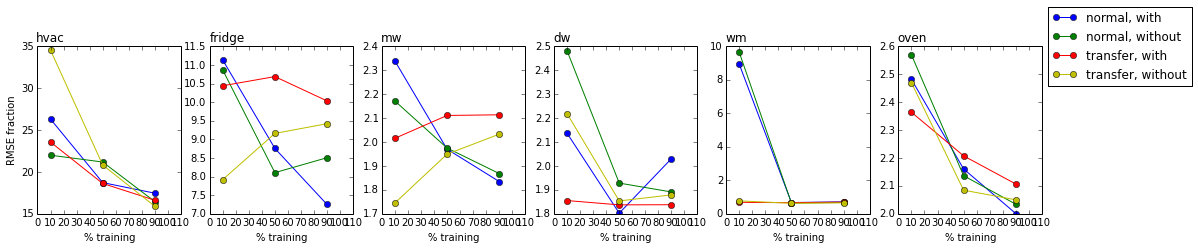

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = mean_out['normal']['static'][appliance]
    df2 = mean_out['normal']['None'][appliance]
    df3 = mean_out['transfer']['static'][appliance]
    df4 = mean_out['transfer']['None'][appliance]
    df = pd.concat([df1, df2, df3, df4], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')

ax[count-1].legend(["normal, with", 'normal, without', 'transfer, with', 'transfer, without'], loc='center left' , bbox_to_anchor=(1, 1))
# plt.savefig("./analysis/0720/with_without_static_.pdf", bbox_inches="tight", dpi=300, format='pdf')

### Read from files

In [15]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        return pickle.load(f)

In [35]:
pred = {}
for method in ['normal', 'transfer']:
    pred[method] = {}
    for algo in ['adagrad', 'gd']:
        pred[method][algo] = {}
        for static_fac in ['static', 'None']:
            pred[method][algo][static_fac] = {}
            for random_seed in range(10):
                pred[method][algo][static_fac][random_seed] = load_obj("pred_static/pred_{}_{}_{}_{}".format(method, algo, static_fac, random_seed))

In [38]:
out = {}

for method in ['normal', 'transfer']:
    out[method] = {}
    for algo in ['adagrad', 'gd']:
        out[method][algo] = {}
        for static_fac  in ['static', 'None']:
            out[method][algo][static_fac] = {}
            for random_seed in range(5):
                out[method][algo][static_fac][random_seed] = {}   
                for appliance in APPLIANCES_ORDER[1:]:
                    print (method, algo, static_fac, random_seed, appliance)
                    out[method][algo][static_fac][random_seed][appliance] = {}
                    for f in range(10,110,40):
                        s = pd.concat(pred[method][algo][static_fac][random_seed][appliance][f]).ix[sd_df.index]
                        if appliance=="hvac":
                            out[method][algo][static_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                        else:   
                            out[method][algo][static_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]


('normal', 'adagrad', 'static', 0, 'hvac')
('normal', 'adagrad', 'static', 0, 'fridge')


/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


('normal', 'adagrad', 'static', 0, 'mw')
('normal', 'adagrad', 'static', 0, 'dw')
('normal', 'adagrad', 'static', 0, 'wm')
('normal', 'adagrad', 'static', 0, 'oven')
('normal', 'adagrad', 'static', 1, 'hvac')
('normal', 'adagrad', 'static', 1, 'fridge')
('normal', 'adagrad', 'static', 1, 'mw')
('normal', 'adagrad', 'static', 1, 'dw')
('normal', 'adagrad', 'static', 1, 'wm')
('normal', 'adagrad', 'static', 1, 'oven')
('normal', 'adagrad', 'static', 2, 'hvac')
('normal', 'adagrad', 'static', 2, 'fridge')
('normal', 'adagrad', 'static', 2, 'mw')
('normal', 'adagrad', 'static', 2, 'dw')
('normal', 'adagrad', 'static', 2, 'wm')
('normal', 'adagrad', 'static', 2, 'oven')
('normal', 'adagrad', 'static', 3, 'hvac')
('normal', 'adagrad', 'static', 3, 'fridge')
('normal', 'adagrad', 'static', 3, 'mw')
('normal', 'adagrad', 'static', 3, 'dw')
('normal', 'adagrad', 'static', 3, 'wm')
('normal', 'adagrad', 'static', 3, 'oven')
('normal', 'adagrad', 'static', 4, 'hvac')
('normal', 'adagrad', 'static

('transfer', 'gd', 'static', 4, 'mw')
('transfer', 'gd', 'static', 4, 'dw')
('transfer', 'gd', 'static', 4, 'wm')
('transfer', 'gd', 'static', 4, 'oven')
('transfer', 'gd', 'None', 0, 'hvac')
('transfer', 'gd', 'None', 0, 'fridge')
('transfer', 'gd', 'None', 0, 'mw')
('transfer', 'gd', 'None', 0, 'dw')
('transfer', 'gd', 'None', 0, 'wm')
('transfer', 'gd', 'None', 0, 'oven')
('transfer', 'gd', 'None', 1, 'hvac')
('transfer', 'gd', 'None', 1, 'fridge')
('transfer', 'gd', 'None', 1, 'mw')
('transfer', 'gd', 'None', 1, 'dw')
('transfer', 'gd', 'None', 1, 'wm')
('transfer', 'gd', 'None', 1, 'oven')
('transfer', 'gd', 'None', 2, 'hvac')
('transfer', 'gd', 'None', 2, 'fridge')
('transfer', 'gd', 'None', 2, 'mw')
('transfer', 'gd', 'None', 2, 'dw')
('transfer', 'gd', 'None', 2, 'wm')
('transfer', 'gd', 'None', 2, 'oven')
('transfer', 'gd', 'None', 3, 'hvac')
('transfer', 'gd', 'None', 3, 'fridge')
('transfer', 'gd', 'None', 3, 'mw')
('transfer', 'gd', 'None', 3, 'dw')
('transfer', 'gd', 'None

In [39]:
mean_out = {}
for method in ['normal', 'transfer']:
    mean_out[method] = {}
    for algo in ['adagrad', 'gd']:
        mean_out[method][algo] = {}
        for static_fac  in ['static', 'None']:
            mean_out[method][algo][static_fac] = pd.Panel(out[method][algo][static_fac]).mean(axis=0)

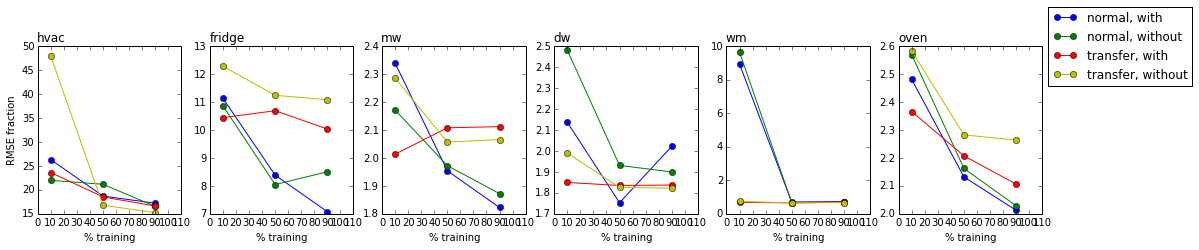

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = mean_out['normal']['gd']['static'][appliance]
    df2 = mean_out['normal']['gd']['None'][appliance]
    df3 = mean_out['transfer']['gd']['static'][appliance]
    df4 = mean_out['transfer']['gd']['None'][appliance]
    df = pd.concat([df1, df2, df3, df4], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')

ax[count-1].legend(["normal, with", 'normal, without', 'transfer, with', 'transfer, without'], loc='center left' , bbox_to_anchor=(1, 1))
# plt.savefig("./analysis/0720/with_without_static_.pdf", bbox_inches="tight", dpi=300, format='pdf')

In [28]:
pred1 = load_obj('pred_static/pred_transfer_gd_static_0')
pred2 = load_obj("pred_transfer_gd_static_0")

In [33]:
out2 = {}
for appliance in APPLIANCES_ORDER[1:]:
    out2[appliance] = {}
    for f in range(10,110,10):
        s = pd.concat(pred2[appliance][f]).ix[sd_df.index]
        if appliance=="hvac":
            out2[appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
        else:   
            out2[appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [34]:
out2

{'dw': {10: 1.8544442656702855,
  20: 1.8736709283651076,
  30: 1.8546221860431766,
  40: 1.8383568004212771,
  50: 1.8353416141540322,
  60: 1.8470403251980754,
  70: 1.8402849176260874,
  80: 1.8409686879526799,
  90: 1.8373816487460439,
  100: 1.8393187619254481},
 'fridge': {10: 10.430766341768784,
  20: 9.6004701491604756,
  30: 9.7582145208514888,
  40: 10.139025317419442,
  50: 10.695458476266895,
  60: 9.8500978127713772,
  70: 10.260667666028388,
  80: 9.8443523545197547,
  90: 10.038001249308135,
  100: 10.030962626494548},
 'hvac': {10: 22.984168264347279,
  20: 17.444807443779769,
  30: 15.976320938420685,
  40: 14.483908759140064,
  50: 18.529075699343245,
  60: 15.821089449575398,
  70: 16.385174438152827,
  80: 15.72839094704754,
  90: 16.629389675207022,
  100: 15.703348143485815},
 'mw': {10: 2.0185218915161376,
  20: 1.9380158173614532,
  30: 1.9588636594830784,
  40: 2.0494381111622491,
  50: 2.1082804592581543,
  60: 2.0669171608191639,
  70: 2.1134395301378479,
  8